In [31]:
# Open CV

In [76]:
# Set to False if we're not on a local machine
local = True
is_on_goolge_collab = "google.colab" in str(get_ipython())
if is_on_goolge_collab:
    local = False
    device_name = tf.test.gpu_device_name()
    ic(device_name)


if not local:
    print("Not on local machine, installing")
    !git clone https://github.com/idvorkin/video-edit/ ~/gits/video-edit
    %mkir ~/downloads
    %cd ~/downloads
    !wget -nc https://files6678.blob.core.windows.net/videos/igor-magic.mp4
    !pip3 install icecream typer
    %cd ~/gits/video-edit

NameError: name 'is_on_google_collab' is not defined

In [33]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import display, Image, clear_output
import os
import cv_helper
from filter_to_motion import *

# import pixellib
# from pixellib.semantic import semantic_segmentation
import torch
import torchvision
from PIL import Image

In [34]:
class remove_background:
    def __init__(self, base_filename, in_fps=30):
        self.base_filename = base_filename
        self.in_fps = in_fps
        self.debug_window_refresh_rate = int(
            self.in_fps / 2
        )  # every 0.5 seconds; TODO Compute
        pass

    def create(self, input_video):
        self.state = FrameState(0, 0)

    def destroy(self):
        pass

    def frame(self, idx, original_frame):
        self.state.idx = idx

        # PERF: Processing at 1/4 size boosts FPS by TK%
        in_frame = shrink_image_half(original_frame)

        # PERF: Motion Mask sampled frames
        motion_mask = to_motion_mask_fast(self.state, in_frame)

        # skip frames with no motion
        if is_frame_black(motion_mask):
            return

        # PERF - show_debug_window at on sampled frames
        if idx % self.debug_window_refresh_rate == 0:
            debug_frame = create_analyze_debug_frame(in_frame, motion_mask)
            burn_in_debug_info(debug_frame, idx, self.in_fps)
            masked_input = cv2.bitwise_and(in_frame, in_frame, mask=motion_mask)
            cv_helper.display_jupyter(masked_input)

In [39]:
input_video_path = os.path.expanduser("~/downloads/igor-magic.mp4")
ic(input_video_path)

ic| input_video_path: '/home/idvorkin/downloads/igor-magic.mp4'


'/home/idvorkin/downloads/igor-magic.mp4'

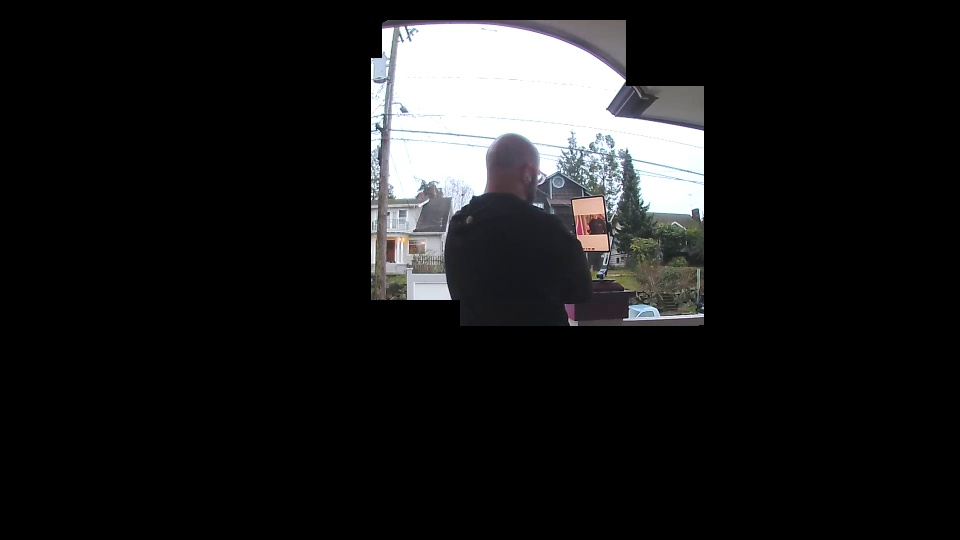

ic| int(fps.fps()): 140, 'Elapsed Seconds', int(fps.elapsed()): 7


In [40]:
rb = remove_background(input_video_path, 30)
cv_helper.process_video(cv_helper.cv2_video(input_video_path), rb)

## Pixel Lab - not great, very slow, and in-consistent set of APIs.

In [5]:
# segment_frame = semantic_segmentation()
# segment_frame.load_ade20k_model(os.path.expanduser("~/downloads/deeplabv3_xception65_ade20k.h5"))

In [6]:
class segment:
    def __init__(self, segmenter, in_fps=30):
        self.segmenter = segmenter  # expensive to initate, cache it.
        self.in_fps = in_fps
        self.debug_window_refresh_rate = int(
            self.in_fps / 2
        )  # every 0.5 seconds; TODO Compute
        pass

    def create(self, input_video):
        pass

    def destroy(self):
        pass

    def frame(self, idx, frame):
        if idx % self.in_fps * 5:
            ret, img = self.segmenter.segmentFrameAsAde20k(frame, overlay=True)
            cv_helper.display_jupyter(img)
            ic(ret.keys())
            ic(ret["class_ids"])
            ic(len(ret["masks"]))
            ic(len(ret["masks"][0]))
            ic(len(ret["masks"][1]))
            ic(len(ret["masks"][2]))
            ic(ret["masks"][14])

In [7]:
# sf = segment(segment_frame,30)
# cv_helper.process_video(cv_helper.cv2_video(input_video_path), sf)

## YoLo v5, Looks awesome!  And it's based on PyTorch, which is kind of nice

In [72]:
from plots import Annotator, colors


class YoloDetector:
    # yolo is a class variable to avoid spurious reloads
    yolo = torch.hub.load(
        "ultralytics/yolov5", "yolov5s"
    )  # or yolov5m, yolov5l, yolov5x, custom

    def __init__(self):
        pass

    def create(self, input_video):
        self.in_fps = input_video.get(cv2.CAP_PROP_FPS)

    def destroy(self):
        ic(self.in_fps)
        pass

    def frame(self, idx, frame):
        # pretty expensive, only do every 10 seconds
        if idx % (self.in_fps * 1) != 0:
            return

        # Inference
        results = self.yolo(frame)
        predictions = results.pred[0]

        # PyTorch uses PIL Format
        # I wonder if I can skip some of these switches
        # You may need to convert the color.
        img_pil = np.ascontiguousarray(
            Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        )

        annotator = Annotator((img_pil))
        for *box, confidence, cls in predictions:
            # ic(cls, confidence, results.names[int(cls)])
            label = f"{results.names[int(cls)]} {confidence:.2f}"
            annotator.box_label(box, label, color=colors(cls))

        # For reversing the operation:
        im_np = np.asarray(annotator.im)
        cv_helper.display_jupyter(im_np)

Using cache found in /home/idvorkin/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-9-5 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


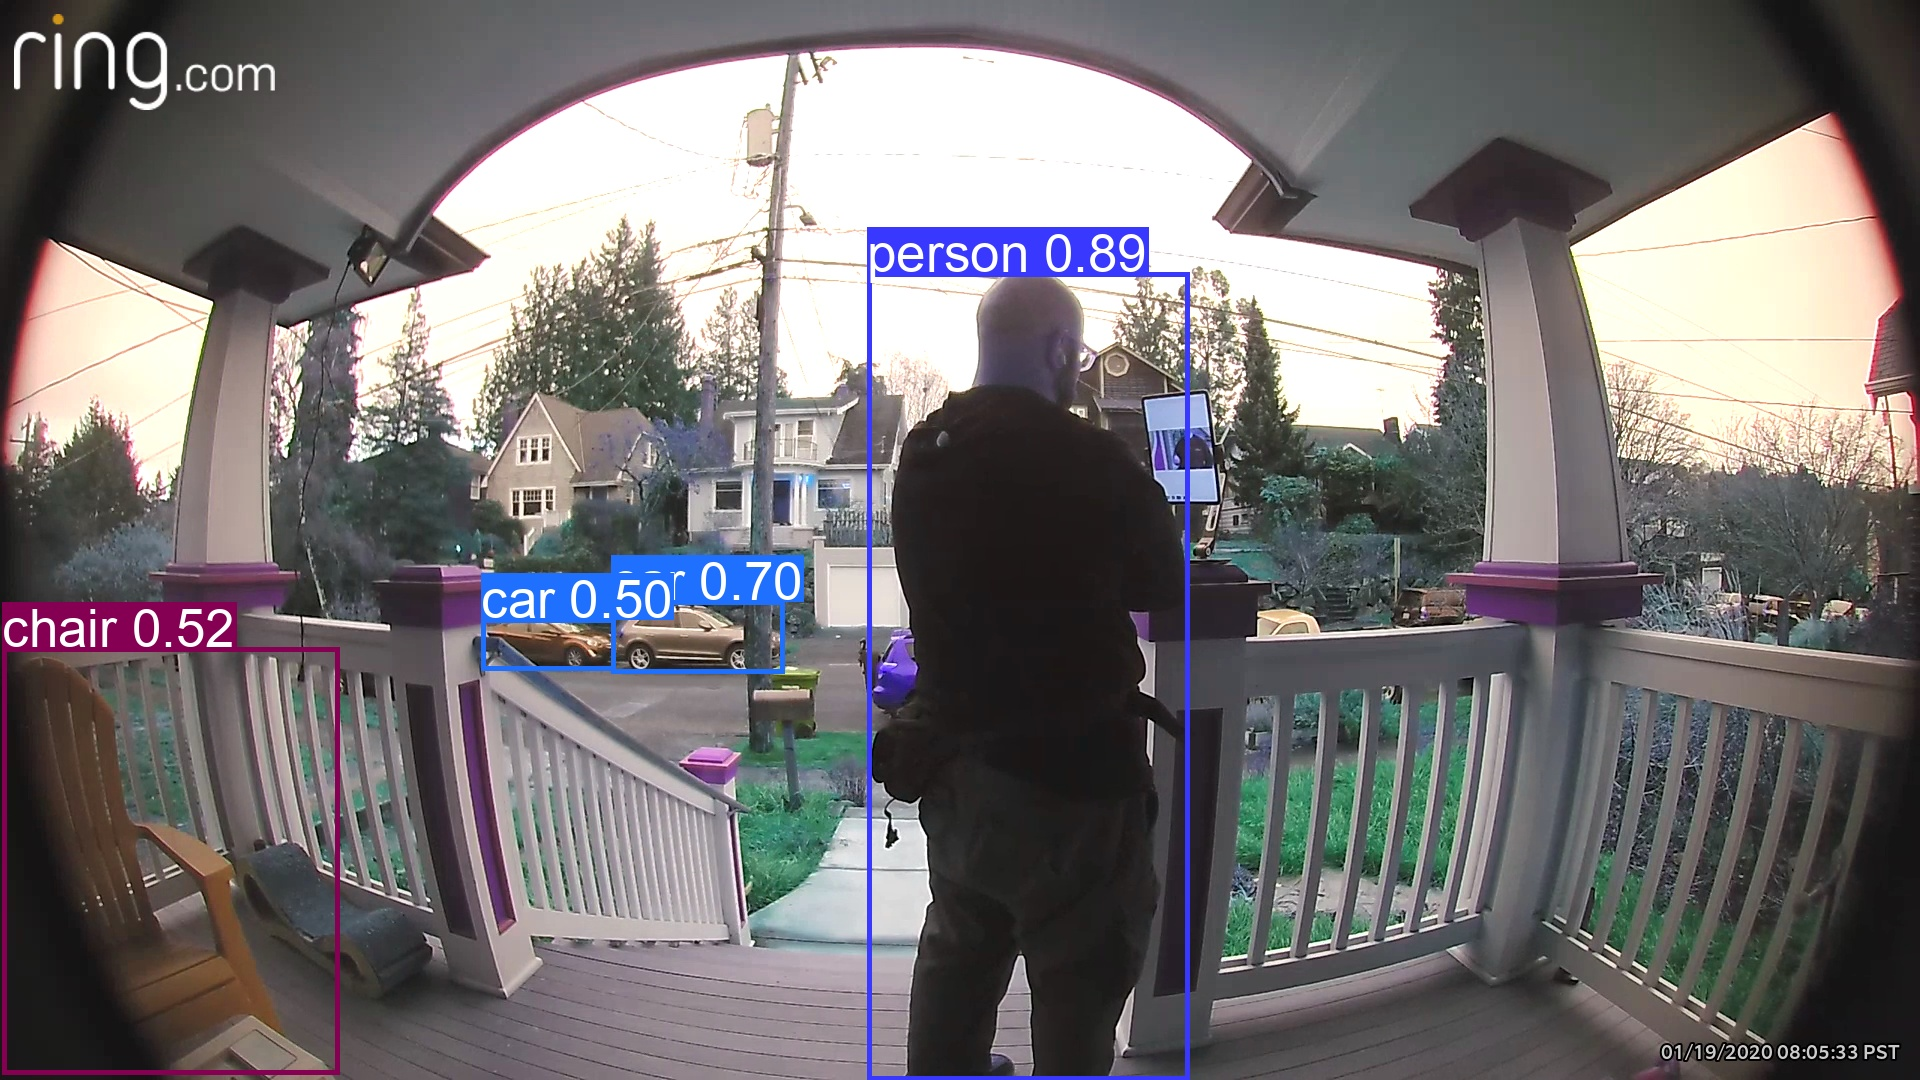

ic| self.in_fps: 15.0
ic| int(fps.fps()): 40, 'Elapsed Seconds', int(fps.elapsed()): 24


In [73]:
# Images
# img = os.path.expanduser('~/downloads/amelia-face.jpg')

yolo = YoloDetector()
input_video = cv2.VideoCapture(input_video_path)
cv_helper.process_video(input_video, yolo)